In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import pendulum
import math
import xgboost as xgb
import pandas_ml as pdml
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier

In [3]:
data = pd.read_csv('data/transport_data.csv', na_values='-')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58665 entries, 0 to 58664
Data columns (total 5 columns):
log           58665 non-null float64
lat           58665 non-null float64
request_ts    58665 non-null int64
trans_ts      58665 non-null int64
label         15000 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
data.describe()

,log,lat,request_ts,trans_ts
count,58665.000000,58665.000000,5.866500e+04,5.866500e+04
mean,30.322805,59.937687,1.512123e+09,1.512123e+09
std,0.057103,0.008279,9.484725e+04,9.484976e+04
min,30.213354,59.922436,1.511957e+09,1.511957e+09
25%,30.293459,59.932198,1.512044e+09,1.512044e+09
50%,30.327059,59.935230,1.512123e+09,1.512123e+09
75%,30.367682,59.942097,1.512208e+09,1.512208e+09
max,30.416616,59.970192,1.512302e+09,1.512302e+09


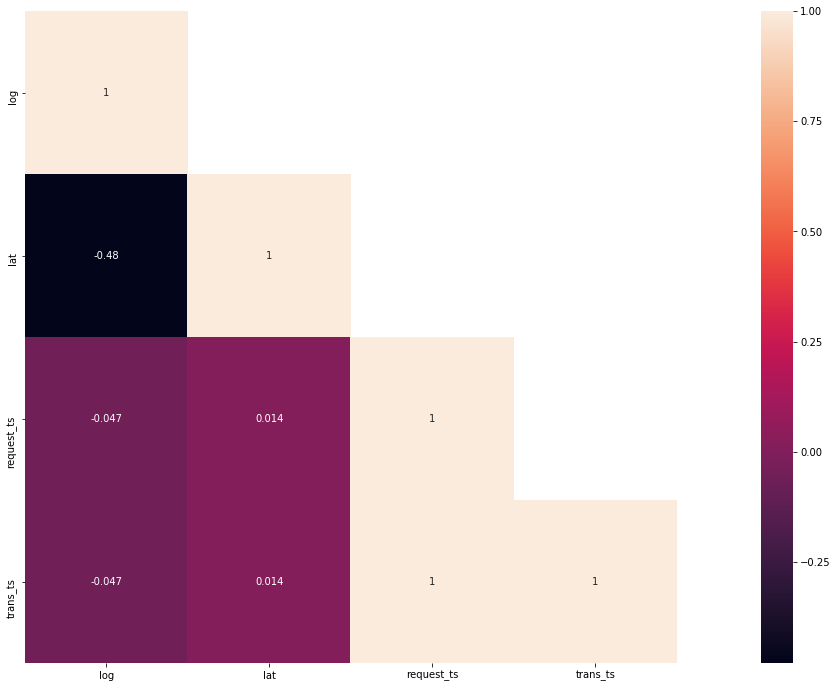

In [6]:
cor_mat = data.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30, 12)
sns.heatmap(data=cor_mat, mask=mask, square=True, annot=True, cbar=True)

In [7]:
data.describe()

,log,lat,request_ts,trans_ts
count,58665.000000,58665.000000,5.866500e+04,5.866500e+04
mean,30.322805,59.937687,1.512123e+09,1.512123e+09
std,0.057103,0.008279,9.484725e+04,9.484976e+04
min,30.213354,59.922436,1.511957e+09,1.511957e+09
25%,30.293459,59.932198,1.512044e+09,1.512044e+09
50%,30.327059,59.935230,1.512123e+09,1.512123e+09
75%,30.367682,59.942097,1.512208e+09,1.512208e+09
max,30.416616,59.970192,1.512302e+09,1.512302e+09


In [8]:
numerical_columns = ['log', 'lat', 'trans_ts', 'request_ts'] 

In [9]:
data_numerical = data[numerical_columns]
data_numerical = (
    data_numerical - data_numerical.mean()) / data_numerical.std()
data_numerical.describe()

,log,lat,trans_ts,request_ts
count,5.866500e+04,5.866500e+04,5.866500e+04,5.866500e+04
mean,-2.426249e-15,-2.619184e-13,9.503689e-13,8.333120e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.916735e+00,-1.842144e+00,-1.755110e+00,-1.753171e+00
25%,-5.139185e-01,-6.630839e-01,-8.307322e-01,-8.305608e-01
50%,7.449068e-02,-2.967876e-01,-2.337908e-03,-2.060274e-03
75%,7.858859e-01,5.325627e-01,8.964203e-01,8.965003e-01
max,1.642847e+00,3.925987e+00,1.890603e+00,1.890246e+00


In [10]:
Y = data['label']

In [11]:
data = pd.concat((data_numerical, Y),
                 axis=1)

In [12]:
unknown = data[data['label'].isnull()]
unknown.shape

(43665, 5)

In [13]:
unknown.drop(['label'], axis=1, inplace=True)

In [14]:
Test = data[data['label']=='?']
Test.drop(['label'],axis=1, inplace=True)
Test.shape

(5000, 4)

In [15]:
Train = data[data['label'].isin(['0','1','2'])]
Train.shape

(10000, 5)

In [16]:
Y = Train['label']
Train.drop(['label'], axis=1, inplace=True)

In [17]:
Y = Y.apply(lambda x: str(x))

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(
    Train, Y, test_size=0.3, random_state=11)

In [19]:
clf = tree.DecisionTreeClassifier(random_state=11)

kf = StratifiedKFold(random_state=11, n_splits=10, shuffle=True)
scores = cross_val_score(clf, Train, Y, cv=kf)
print("CV:", np.mean(scores)) 

kf = StratifiedKFold(random_state=11, n_splits=10, shuffle=True)
clf = BaggingClassifier(clf, random_state=11)
scores = cross_val_score(clf, Train, Y, cv=kf)
print("CV:", np.mean(scores))

clf = CalibratedClassifierCV(clf, method='sigmoid', cv=StratifiedKFold(random_state=11, n_splits=10, shuffle=True))
scores = cross_val_score(clf, Train, Y, cv=kf)
print("CV:", np.mean(scores))


CV: 0.5683052864376218
CV: 0.5902975313825614
CV: 0.6136010564675235


In [20]:
clf.fit(Train, Y)

CalibratedClassifierCV(base_estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
       ..._estimators=10, n_jobs=None, oob_score=False,
         random_state=11, verbose=0, warm_start=False),
            cv=StratifiedKFold(n_splits=10, random_state=11, shuffle=True),
            method='sigmoid')

In [21]:
Y_pr = clf.predict(Test)
Y_pr = pd.DataFrame(Y_pr)
Y_pr.to_csv('Y_pr.csv', index=None, header=None)